In [ ]:
!pip install bertopic gensim spacy pymorphy3 fasttext-langdetect natasha

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
import spacy
import pymorphy3
from ftlangdetect import detect as ftdetect
import string
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from copy import deepcopy
import unicodedata
from natasha import MorphVocab
import numpy as np
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
import numpy as np
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import shapiro

In [ ]:
df = pd.read_csv("questions_without_material.csv")

In [5]:
df.head(5)

,id,Пакет,№,Вопрос,Ответ,Зачет,Комментарий,Источник,Авторы,Доля взятия,Процент взятия,Год
0,1,Умлаут Special: Сова в пабе 2019,1.0,"В передаче Андрея Понкратова рассказывается, ч...",Носами,Нос,Приветствие касанием носа – традиция жителей с...,https://youtu.be/BW63sNTOD8Q?t=1513,"Андрей Кунилов (Мюнхен), Марина Парр (Мюнхен)",120/132,91.0,2018_2019
1,2,Умлаут Special: Сова в пабе 2019,2.0,Одна из сцен “Московского центра драматургии и...,выключать мобильные телефоны,"выключать сотовые телефоны, синонимичные ответы",перед началом спектакля голос по громкоговорит...,https://typical-moscow.ru/mama-cdr-istoriya-od...,"Андрей Кунилов (Мюнхен), Марина Парр (Мюнхен)",107/132,81.0,2018_2019
2,3,Умлаут Special: Сова в пабе 2019,3.0,"Статья ""National Geographic"" ""ПРОПУСК тела про...",пластика,точный ответ,"В фотопроекте Григория Шелухина ""Крохотная сме...",http://www.nat-geo.ru/planet/1190948-plastika-...,Борис Рабинович (Тель-Авив),93/132,70.0,2018_2019
3,4,Умлаут Special: Сова в пабе 2019,4.0,"Фантастическое животное демимаска, придуманное...",Нострадамус,Точный ответ,Особо неуязвимым демимаску делает способность ...,https://ru.wikipedia.org/wiki/Нострадамус,Борис Рабинович (Тель-Авив),40/132,30.0,2018_2019
4,5,Умлаут Special: Сова в пабе 2019,5.0,В постановке мюнхенского детского театра один ...,[вместо] мозгов,"[вместо] ума. Зачет по слову “мозг”, “ум”, “ра...",Речь о постановке Волшебника страны Оз. В сцен...,NaN,Максим Мозуль (Мюнхен),44/132,33.0,2018_2019


## Метрики

In [ ]:
def get_sil_score(embeddings: np.ndarray, topics: list[int]) -> float:
    """
    Вычисляет силуэтный коэффициент для кластеризованных данных.
    
    Args:
        embeddings: Массив эмбеддингов документов
        topics: Список меток кластеров
        
    Returns:
        Среднее значение силуэтного коэффициента
    """
    topics = np.array(topics)
    valid_indices = topics != -1
    filtered_embeddings = embeddings[valid_indices]
    filtered_topics = topics[valid_indices]
    silhouette_avg = silhouette_score(filtered_embeddings, filtered_topics)
    return silhouette_avg

### Предобработка

In [ ]:
morph_ru = pymorphy3.MorphAnalyzer(lang="ru")
nlp_ru = spacy.load("ru_core_news_sm", disable=["parser", "ner"])
punctuation = set(string.punctuation + "«»…")
morph_vocab = MorphVocab()

def lemmatize(text: str, keep_composite: bool = True) -> list[str]:
    """
    Лемматизирует текст, преобразуя слова в их нормальную форму.
    Параметры:
        text (str): Входной текст для обработки
        keep_composite (bool): Флаг сохранения составных слов (через дефис). 
                               Если True и в тексте есть дефис, слово возвращается как есть.
                               
    Возвращает:
        list[str]: Список лемм и знаков пунктуации в порядке их появления
    """
    if keep_composite and '-' in text:
        return [text.lower()]
    
    doc = nlp_ru(text.lower())
    lemmas = []
    for token in doc:
        if token.text.strip() == "":
            continue
        if token.text in punctuation:
            lemmas.append(token.text)
        else:
            lemma = morph_ru.parse(token.text)[0].normal_form
            lemmas.append(lemma)
    return lemmas

def lemmatize_text(text: str) -> str:
    return " ".join(lemmatize(text))

def lemmatize_stopwords(stopwords: set[str]) -> set[str]:
    text = " ".join(stopwords)
    return set(lemmatize(text))


In [ ]:
nltk.download("stopwords")
stopwords_ru = set(stopwords.words("russian"))
custom_stopwords = {'30', 'query', 'автор', 'альф', 'альфа', 'бета', 'буква', 'век', 'вид', 'вопрос', 'восстановить', 'время',
                    'второе', 'второй', 'год', 'город', 'двумя', 'делать', 'другой', 'её', 'замена', 'заменить', 'заменять',
                    'заполнить', 'игрек', 'известный', 'изз', 'изменить', 'икс', 'именно', 'исходный', 'каждый', 'какой',
                    'который', 'кто', 'название', 'назвать', 'называть', 'написать', 'начинаться', 'обсуждение', 'один',
                    'односложный', 'он', 'оно','ответ','ответить','первый','писать','подобный','поэтому','предложение',
                    'предыдущий','пример','пропуск','пропуск1','пропуск2','пропустить','сделать','секунда','слово',
                    'словосочетание','страна','сякой','также','такой','тот','третий','три','упоминаться','это', 'сам', 
                    'свой', 'ответить', 'такой', 'некоторый', 'например', 'xix', 'любой', 'считаться', 'сказать', 'начало',
                    'недавно', 'какоеть', 'чтоть', 'xvii', 'описать', '1960ха', 'цзеф', 'являться', 'сравнить', 'we',
                    'коллодить', 'парный','заниматься', 'рушдить', '4050', '1910xa', 'утверждать','использовать',
                    'увидеть', 'бува', 'напрямую', 'некий', 'ii', 'установить', 'тысяча', 'являться', 'хотеть',
                    'произойти', 'бут', 'своё', '1914', 'остального', 'xx', 'final', 'blacks', 'whenua', 'века', 'фалек',
                    'норрис', 'джеймс', 'видов', 'блэкс', 'yahoo', '1860', 'писал', 'ройс', '407', 'однажды', 'стать',
                    'говорить', 'очень','просить', 'сравнивать', 'несколько', 'середина', 'джон', 'удаться', 'алфавит', 
                    'соседний', 'рассказывать', 'сравнивать', 'британский', 'имя', 'согласный', 'набоков', 'считать', 
                    'евгений', 'отмечать', 'четыре', 'человек', 'изобразить', 'посвятить', 'называться', 'показать', 
                    'означать', 'сяня', 'использоваться', 'макс'}
all_stopwords = stopwords_ru.union(custom_stopwords)

lemm_stopwords = list(lemmatize_stopwords(all_stopwords).union(all_stopwords))

def preprocess_text(text: str,
                    remove_punctuation: bool = True,
                    lemmatize: bool = True,
                    stopwords: bool = True,
                    remove_numbers: bool = True) -> list:
    
    """
    Предварительная обработка текста с возможностью:
    - удаления пунктуации
    - лемматизации слов
    - фильтрации стоп-слов
    - удаления числовых токенов
    
    Параметры:
        text (str): Исходный текст для обработки
        remove_punctuation (bool): Удалять знаки пунктуации (по умолчанию True)
        lemmatize (bool): Приводить слова к нормальной форме (по умолчанию True)
        stopwords (bool): Удалять стоп-слова (по умолчанию True)
        remove_numbers (bool): Удалять числовые токены (по умолчанию True)
    
    Возвращает:
        list[str]: Список обработанных токенов

    """
    
    if remove_punctuation:
        text = re.sub(r"[^\w\s]", "", str(text))

    tokens = re.findall(r"\w+", text.lower())
    processed_tokens = []

    for token in tokens:
        if remove_numbers and token.isdigit():
            continue
        if stopwords and token in lemm_stopwords:
            continue
        if lemmatize:
            token = lemmatize_text(token)
            if stopwords and token in lemm_stopwords:
                continue
            

        processed_tokens.append(token)

    return processed_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/melondent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Шаблоны регулярных выражений для удаления повторяющихся структурных паттернов
patterns_to_remove = [
    r"(?i)(ответьте|назовите)\s+(?:\w+\W+){0,4}(двумя|тремя|четырьмя|одним)\s+слов(ами|ом)",
    r"(?i)(ответьте|назовите)",
    r"\bСДЕЛАТЬ ЭТО\b|\bДЕЛАТЬ ЭТО\b",
    r"\bТАМ\b",
    r"\bОН\b",
    r"\bИХ\b",
    r"\bЕ[ЕЁË]\b",
    r"\bИМ\b",
    r"\bЕЙ\b",
    r"(?i)\bв этом вопросе\b",
    r"(?i)\b(вопрос[а-яё]*|слов[а-яё]*|букв[а-яё]*|эт[а-яё]*|друг[а-яё]*)\b",
    r"(?i)\b(замен[а-яё]*|измен[а-яё]*|перемен[а-яё]*)\b",
    r"(?i)(соседние буквы алфавита|последовательные буквы алфавита)",
    r"(?i)\bмы\b(?:\s+\S+){0,4}?\s+\bсократили\b",
    r"(?i)\b(пропущ(ен[аоы]?|или|ить)|убрали|пропустили)\b(?:\s+\S+){0,4}?\s+\bбукв[аы]?\b",
    r"(?i)\b(назовите|напишите|закончите|как(ая|ое|ие)|как)\b(?:\s+\S+){0,4}?\s+\b(фамили[юяейи]|им[яени]|звали)\b",
    r"(?i)\b(икс|игрек|альф|бет)\b",
    r"(?i)\b(он|она|оно|они|их|его|ей|ем|ими|им|е[её]|это)\b",
    r"(?i)\bпропуск(и|ами|ов)?\b|\bмы пропустили\b",
    r"(?i)\b(мы|что)\b(?:\s+\S+){0,4}?\s+\b(заменили|изменили)\b",
    r"(?i)\bтак(ой|ая|ое|ие|ими|им)?\b",
    r"(?i)\bчто\b"]

    
def remove_patterns(text: str) -> str:
    """
    Очищает текст структурных паттернов
    
    Параметры:
        text (str): Исходный текст для очистки
    
    Возвращает:
        str: Очищенный текст
    """
    text = str(text)
    
    text = re.sub(r'\w*[А-ЯЁ]{3,}\w*', '', text)    
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'\b[А-Яа-яЁё]\b', '', text)
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
    
    text = re.sub(r'\?+', '', text)
    text = re.sub(r'\:+', '', text)
    text = re.sub(r'\"+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['Вопрос'].apply(remove_patterns)

In [10]:
docs = list(df["cleaned_text"].apply(str).apply(lambda x: f"query: {x}"))
df["fully_processed_text"] = df["cleaned_text"].apply(lambda x: " ".join(preprocess_text(x)))
docs_tfidf = list(df["fully_processed_text"])

### Работа с BERTopic (DBSCAN)

In [ ]:
model = SentenceTransformer("ai-forever/sbert_large_nlu_ru")
embedds = model.encode(docs, show_progress_bar=True)

In [12]:
np.save("topic_embeddings_rubert.npy", embedds)

In [ ]:
embedds = np.load("topic_embeddings_rubert.npy")

In [17]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

vectorizer_model = CountVectorizer(stop_words=lemm_stopwords)

umap_model = UMAP(n_neighbors=15, n_components=5,
                  min_dist=0.05, metric="cosine", random_state=42)

hdbscan_model = HDBSCAN(
    min_cluster_size=20,  
    min_samples=5,        
    cluster_selection_epsilon=0.2
)

topic_model = BERTopic(embedding_model="ai-forever/sbert_large_nlu_ru",
                       vectorizer_model=vectorizer_model,
                       nr_topics="auto",
                       verbose=True,
                       umap_model=umap_model,
                       ctfidf_model=ctfidf_model,
                       hdbscan_model=hdbscan_model,
                       top_n_words=100)

topics, probs = topic_model.fit_transform(docs, embeddings=embedds)

2025-06-02 04:57:04,472 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-06-02 04:57:30,513 - BERTopic - Dimensionality - Completed ✓
2025-06-02 04:57:30,527 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-02 04:57:30,730 - BERTopic - Cluster - Completed ✓
2025-06-02 04:57:30,731 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-02 04:57:31,004 - BERTopic - Representation - Completed ✓
2025-06-02 04:57:31,005 - BERTopic - Topic reduction - Reducing number of topics
2025-06-02 04:57:31,036 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-02 04:57:31,285 - BERTopic - Representation - Completed ✓
2025-06-02 04:57:31,288 - BERTopic - Topic reduction - Reduced number of topics from 19 to 15


In [18]:
umap_model = UMAP(n_neighbors=15, n_components=2,
                  min_dist=0.05, metric="cosine", random_state=42)

reduced_embeddings = umap_model.fit_transform(embedds)

get_sil_score(reduced_embeddings, topics)

0.30771536

In [19]:
topic_model.visualize_barchart(top_n_topics=30, n_words=20)


In [22]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1343,-1_одной_романа_какое_году,"[одной, романа, какое, году, которые, одного, ...",[query: По сюжету “Женитьбы Фигаро” пажа графа...
1,0,204,0_персонаж_герой_персонажа_картине,"[персонаж, герой, персонажа, картине, одного, ...","[query: Герой Веры Богдановой, работавший круп..."
2,1,168,1_напишите_исходном_виде_заполните,"[напишите, исходном, виде, заполните, предложе...",[query: Один из переводчиков Гомера на латынь ...
3,2,129,2_войны_король_года_году,"[войны, король, года, году, военные, франко, м...",[query: Революция на Кубе вызвала восторг сред...
4,3,116,3_учёные_развитие_обнаружили_птицы,"[учёные, развитие, обнаружили, птицы, способны...",[query: Около 400 миллионов лет назад некоторы...
5,4,98,4_футбольный_футболистов_команды_спорта,"[футбольный, футболистов, команды, спорта, игр...","[query: автора , который услышал от своего зна..."
6,5,98,5_богам_роллс_символ_древние,"[богам, роллс, символ, древние, значением, озн...","[query: Есть версия, реформа 15 века связана г..."
7,6,92,6_чай_еды_приготовления_блюда,"[чай, еды, приготовления, блюда, пекарне, меню...",[query: Праздник середины осени Китае отмечают...
8,7,83,7_роман_текст_поэта_сергея,"[роман, текст, поэта, сергея, поэт, писатель, ...",[query: Учёный Николай Николаевич Гуртовой соб...
9,8,77,8_группы_песен_песни_музыки,"[группы, песен, песни, музыки, музыке, рэпер, ...",[query: молодости рэпер Бобби Шмёрда жил небла...


In [23]:
vectorizer = CountVectorizer(stop_words=lemm_stopwords)
X_counts = vectorizer.fit_transform(docs_tfidf) 

transformer = ClassTfidfTransformer(reduce_frequent_words=True)
transformer.fit(X_counts)
X_ctfidf = transformer.transform(X_counts)

topic_model.c_tf_idf = X_ctfidf
topic_model.update_topics(docs_tfidf, vectorizer_model=vectorizer, top_n_words=15)

In [24]:
topic_model.visualize_barchart(top_n_topics=20, n_words=40)

In [ ]:
df['original_text'] = df['Вопрос']
df['topic_id'] = topics 

def show_cluster_documents(topic_model: BERTopic, df: pd.DataFrame, n_samples: int = 15) -> None:
    """
    Визуализирует документы по кластерам с примерами текстов и ключевыми словами.
    
    Для каждого топика выводит:
    - Идентификатор топика
    - Количество документов в кластере
    - Примеры документов (случайная выборка)
    
    Параметры:
        topic_model (BERTopic): Обученная модель BERTopic
        df (pd.DataFrame): DataFrame с текстами и метками топиков
        n_samples (int): Количество примеров документов для отображения на топик
        
    Возвращает:
        None
    """
    
    for topic_id in sorted(df['topic_id'].unique()):
        cluster_docs = df[df['topic_id'] == topic_id]
        
        print(f"\n=== Топик {topic_id} ===")
        print(f"Количество документов: {len(cluster_docs)}")
        
        if topic_id != -1:  # -1 - это шумовые документы
            top_words = [word for word, _ in topic_model.get_topic(topic_id)[:25]]
            print(f"Топ-слова: {top_words}")
        
        # Выводим примеры документов
        print("\nПримеры документов:")
        for _, row in cluster_docs.sample(min(n_samples, len(cluster_docs)), random_state=42).iterrows():
            print(f"\n- {row['original_text']}")

show_cluster_documents(topic_model, df, n_samples=10)


=== Топик -1 ===
Количество документов: 1343

Примеры документов:

- В античном лирическом стихотворении ветреная Аттис бежит к некой Андромеде. Видовое название «atthis» получила птица, которая, согласно Аристотелю, прилетает зимовать... Куда именно?

- В одной битве на Великих равнинах в Северной Америке из-за луговых собачек погибло и было травмировано множество всадников. В Европе к подобным последствиям иногда приводила деятельность ИКСОВ. Чьим женихом был ИКС?

- На картине Яна ван Эйка молодой мужчина делает предложение девушке. Ван Эйк подчеркивает, что юноша ждет от девушки ответа, так как центральное положение на картине занимает ОНО. Назовите ЕГО коротким словом.

- Бабочки монархи каждый год мигрируют с севера США на юг. Распространённое поверье о бабочках связано в том числе с тем, что они прибывают на место своей зимовки к празднику. К какому?

- В колоде таро, тема которой — дикая природа, ОНА изображена на карте с названием «Повешенный». Назовите ЕЁ двумя словами, начи

In [26]:
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings,
                                hide_document_hover=True, hide_annotations=True)

In [27]:
topic_info = topic_model.get_topic_info()
custom_names = {
    -1: "Шум",
    0: "Произведения и персонажи",
    1: "Языки и загадки",
    2: "История, войны и правители",
    3: "Наука и природа",
    4: "Спорт и игры",
    5: "Религии и традиции",
    6: "Еда и напитки",
    7: "Литература",
    8: "Музыка",
    9: "Кино, сериалы и актеры",
    10: "Архитектура",
    11: "Технологии",
    12: "Люди и события",
    13: "Медицина"}

topic_model.set_topic_labels(custom_names)

print(topic_model.get_topic_info()[['Topic', 'Name']])

    Topic                                     Name
0      -1     -1_роман_герой_персонаж_произведение
1       0    0_персонаж_герой_картина_произведение
2       1               1_роман_язык_фраза_вариант
3       2         2_война_король_корабль_испанский
4       3        3_учёный_животное_обнаружить_рыба
5       4           4_команда_футбольный_игра_матч
6       5                  5_древний_бог_язык_грех
7       6        6_еда_блюдо_напиток_приготовление
8       7      7_роман_книга_произведение_писатель
9       8        8_песня_музыка_группа_музыкальный
10      9               9_фильм_актёр_съёмка_герой
11     10     10_отель_построить_здание_берлинский
12     11       11_автомобиль_модель_знак_водитель
13     12              12_харьков_родный_крикун_ме
14     13  13_болезнь_пациент_повивальный_полидорь


In [28]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,1343,-1_роман_герой_персонаж_произведение,Шум,"[роман, герой, персонаж, произведение, героиня...",[query: По сюжету “Женитьбы Фигаро” пажа графа...
1,0,204,0_персонаж_герой_картина_произведение,Произведения и персонажи,"[персонаж, герой, картина, произведение, сериа...","[query: Герой Веры Богдановой, работавший круп..."
2,1,168,1_роман_язык_фраза_вариант,Языки и загадки,"[роман, язык, фраза, вариант, персонаж, компан...",[query: Один из переводчиков Гомера на латынь ...
3,2,129,2_война_король_корабль_испанский,"История, войны и правители","[война, король, корабль, испанский, мировой, г...",[query: Революция на Кубе вызвала восторг сред...
4,3,116,3_учёный_животное_обнаружить_рыба,Наука и природа,"[учёный, животное, обнаружить, рыба, птица, ди...",[query: Около 400 миллионов лет назад некоторы...
5,4,98,4_команда_футбольный_игра_матч,Спорт и игры,"[команда, футбольный, игра, матч, футболист, ч...","[query: автора , который услышал от своего зна..."
6,5,98,5_древний_бог_язык_грех,Религии и традиции,"[древний, бог, язык, грех, семья, церковный, с...","[query: Есть версия, реформа 15 века связана г..."
7,6,92,6_еда_блюдо_напиток_приготовление,Еда и напитки,"[еда, блюдо, напиток, приготовление, чай, рест...",[query: Праздник середины осени Китае отмечают...
8,7,83,7_роман_книга_произведение_писатель,Литература,"[роман, книга, произведение, писатель, поэт, ч...",[query: Учёный Николай Николаевич Гуртовой соб...
9,8,77,8_песня_музыка_группа_музыкальный,Музыка,"[песня, музыка, группа, музыкальный, музыкант,...",[query: молодости рэпер Бобби Шмёрда жил небла...


In [29]:
fig = topic_model.visualize_barchart(
    top_n_topics=20,
    n_words=40,
    width=300,
    height=250,
    custom_labels=custom_names
)

fig.show()

In [ ]:
df["Длина"] = df["Вопрос"].apply(lambda x: len(str(x).split()))

def show_cluster_documents_with_stats(topic_model: BERTopic, 
                                     df: pd.DataFrame, 
                                     n_samples: int = 15, 
                                     show_distributions: bool = False) -> pd.DataFrame:
    """
    Анализирует кластеры документов с выводом статистики и примеров текстов.
    
    Для каждого кластера выводит:
    - Базовую информацию (ID, количество документов)
    - Статистику длины текстов (среднее, медиана)
    - Статистику успешности (если есть столбец 'Процент взятия')
    - Топ-ключевые слова
    - Примеры документов
    - Визуализацию распределения длин
    
    Параметры:
        topic_model (BERTopic): Обученная тематическая модель
        df (pd.DataFrame): DataFrame с текстами и метками кластеров
        n_samples (int): Количество примеров документов на кластер
        show_distributions (bool): Включать визуализацию распределений
        
    Возвращает:
        pd.DataFrame: Статистика по кластерам
    """
    cluster_stats = []
    
    for topic_id in sorted(df['topic_id'].unique()):
        cluster_docs = df[df['topic_id'] == topic_id]
        
        mean_length = cluster_docs['Длина'].mean()
        median_length = cluster_docs['Длина'].median()
        mean_success = cluster_docs['Процент взятия'].mean()
        median_success = cluster_docs['Процент взятия'].median()
        count = len(cluster_docs)
        
        cluster_stats.append({
            'topic_id': topic_id,
            'count': count,
            'mean_length': mean_length,
            'median_length': median_length,
            'mean_success': mean_success,
            'median_success': median_success
        })
        
        print(f"\n=== Топик {topic_id} ===")
        print(f"Количество документов: {count}")
        print(f"Средняя длина: {mean_length:.1f}, Медианная длина: {median_length:.1f}")
        print(f"Средний % взятия: {mean_success:.1f}%, Медианный % взятия: {median_success:.1f}%")
        
        if topic_id != -1:
            top_words = [word for word, _ in topic_model.get_topic(topic_id)[:25]]
            print(f"Топ-слова: {', '.join(top_words)}")
        
        print("\nПримеры документов:")
        for _, row in cluster_docs.sample(min(n_samples, len(cluster_docs)), random_state=42).iterrows():
            print(f"\n- {row['original_text']}")
            
        if show_distributions and not cluster_docs.empty:
            print("\nРаспределение длины вопросов:")
            print(cluster_docs['Длина'].describe())

            # Визуализация для кластера
            plt.figure(figsize=(8, 3))
            sns.histplot(cluster_docs['Длина'], bins=20)
            plt.title(f'Распределение длины вопросов в кластере {topic_id}')
            plt.show()
    
    return pd.DataFrame(cluster_stats)


# Используем функцию с включенной визуализацией распределений
cluster_stats_df = show_cluster_documents_with_stats(topic_model, df, n_samples=0, show_distributions=True)

In [ ]:
from scipy import stats

def calculate_correlations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Рассчитывает корреляцию Спирмена между длиной вопроса и процентом взятия 
    для каждого тематического кластера.
    
    Для каждого кластера вычисляет:
    - Коэффициент корреляции Спирмена
    - p-значение статистической значимости
    - Количество вопросов в кластере
    
    Параметры:
        df (pd.DataFrame): DataFrame с данными:
                           'topic_id', 'Длина', 'Процент взятия'
    
    Возвращает:
        pd.DataFrame: Результаты корреляционного анализа по кластерам
    """
    corr_results = []
    for topic_id in sorted(df['topic_id'].unique()):
        cluster_data = df[df['topic_id'] == topic_id]
        if len(cluster_data) > 1:  # Нужно хотя бы 2 наблюдения для корреляции
            corr, p_value = stats.spearmanr(cluster_data['Длина'], cluster_data['Процент взятия'])
            corr_results.append({
                'topic_id': topic_id,
                'correlation': corr,
                'p_value': p_value,
                'n_questions': len(cluster_data)
            })
    
    return pd.DataFrame(corr_results)

corr_df = calculate_correlations(df)
print(corr_df.sort_values('correlation', ascending=False))

    topic_id  correlation   p_value  n_questions
4          3     0.088097  0.347016          116
12        11     0.082805  0.652311           32
0         -1     0.039155  0.151537         1343
1          0     0.033173  0.637619          204
8          7     0.030323  0.785526           83
9          8     0.023129  0.841747           77
6          5    -0.008955  0.930260           98
11        10    -0.038783  0.827612           34
7          6    -0.042301  0.688882           92
5          4    -0.066764  0.513641           98
2          1    -0.081551  0.293314          168
3          2    -0.165829  0.060361          129
13        12    -0.170613  0.367370           30
14        13    -0.187500  0.428598           20
10         9    -0.318737  0.005013           76


In [41]:
success_by_topic = df.groupby('topic_id')['Процент взятия'].agg(['mean', 'std', 'count'])
print(success_by_topic.sort_values('mean', ascending=False))

               mean        std  count
topic_id                             
 4        55.051020  27.076590     98
 10       52.676471  24.751762     34
 9        51.723684  25.919670     76
 6        48.086957  25.649648     92
 2        47.961240  24.605450    129
 11       46.250000  22.755361     32
 7        45.915663  23.138609     83
-1        45.745346  23.934786   1343
 13       45.300000  25.866255     20
 0        44.975490  22.758626    204
 8        43.831169  26.489026     77
 5        42.081633  26.690542     98
 3        41.706897  25.457900    116
 1        41.642857  23.986095    168
 12       40.200000  23.269634     30


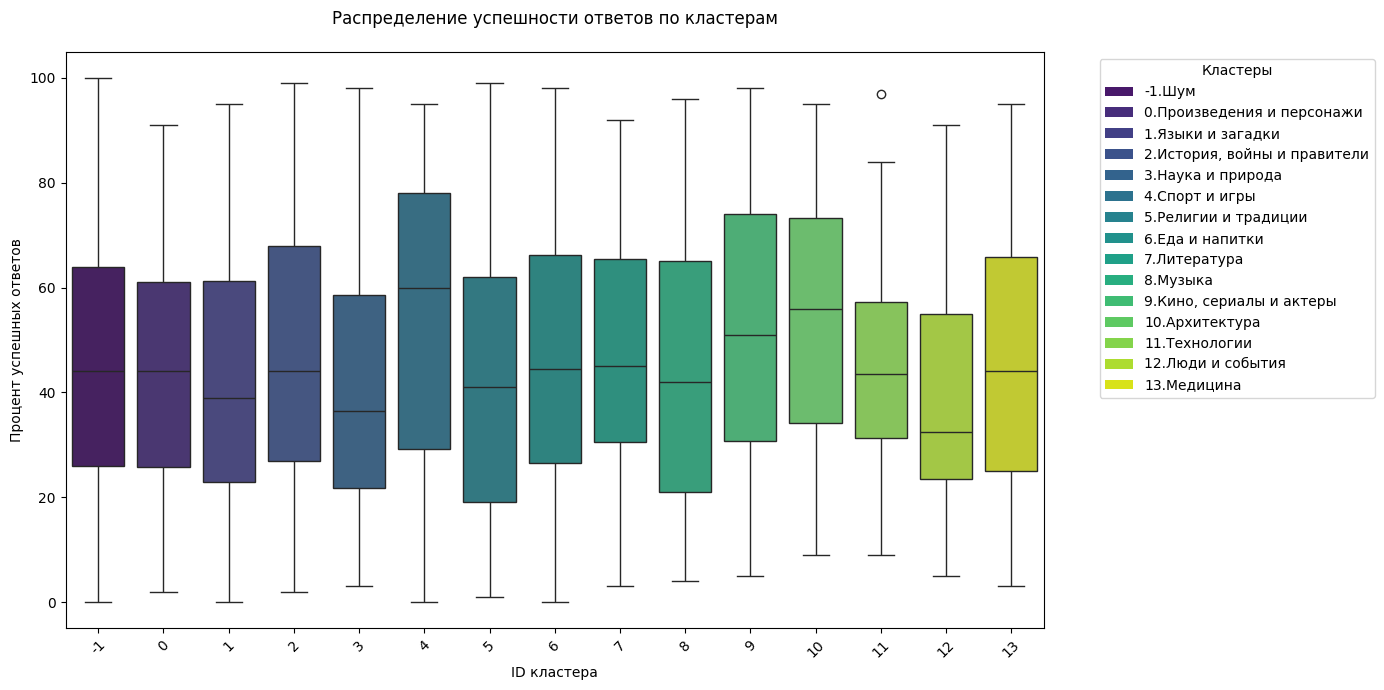

In [ ]:
plt.figure(figsize=(14, 7))

ax = sns.boxplot(x='topic_id', y='Процент взятия', data=df, palette='viridis')

custom_names = {
    -1: "-1.Шум",
    0: "0.Произведения и персонажи",
    1: "1.Языки и загадки",
    2: "2.История, войны и правители",
    3: "3.Наука и природа",
    4: "4.Спорт и игры",
    5: "5.Религии и традиции",
    6: "6.Еда и напитки",
    7: "7.Литература",
    8: "8.Музыка",
    9: "9.Кино, сериалы и актеры",
    10: "10.Архитектура",
    11: "11.Технологии",
    12: "12.Люди и события",
    13: "13.Медицина"
}

handles = []
palette = sns.color_palette("viridis", len(custom_names))

for i, (topic_id, name) in enumerate(custom_names.items()):
    if topic_id in df['topic_id'].unique():
        handles.append(plt.Rectangle((0,0), 1, 1, fc=palette[i], label=name))

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Кластеры')

plt.title('Распределение успешности ответов по кластерам', pad=20)
plt.xlabel('ID кластера')
plt.ylabel('Процент успешных ответов')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
groups = [group['success_rate'].values for name, group in df.groupby('topic_id')]

h_stat, p_value = kruskal(*groups)
print(f"Результат Крускала-Уоллиса: H = {h_stat:.3f}, p-value = {p_value:.3f}")

Результат Крускала-Уоллиса: H = 33.644, p-value = 0.002


In [ ]:
for topic in df['topic_id'].unique():
    data = df[df['topic_id'] == topic]['success_rate']
    stat, p = shapiro(data)
    print(f"Топик {topic}: p-value = {p:.3f} {'(нормальное)' if p > 0.05 else '(не нормальное)'}")

Топик -1: p-value = 0.000 (не нормальное)
Топик 0: p-value = 0.001 (не нормальное)
Топик 8: p-value = 0.004 (не нормальное)
Топик 4: p-value = 0.000 (не нормальное)
Топик 9: p-value = 0.016 (не нормальное)
Топик 11: p-value = 0.326 (нормальное)
Топик 5: p-value = 0.002 (не нормальное)
Топик 1: p-value = 0.002 (не нормальное)
Топик 3: p-value = 0.000 (не нормальное)
Топик 7: p-value = 0.074 (нормальное)
Топик 2: p-value = 0.001 (не нормальное)
Топик 13: p-value = 0.743 (нормальное)
Топик 6: p-value = 0.007 (не нормальное)
Топик 12: p-value = 0.116 (нормальное)
Топик 10: p-value = 0.172 (нормальное)


In [ ]:
# Группируем по темам и считаем среднюю длину вопроса
topic_length = df.groupby('topic_id')['Длина'].agg(['mean', 'count', 'std'])
topic_length = topic_length.rename(columns={'mean': 'Длина'})

topic_length['topic_name'] = topic_length.index.map(custom_names)

# Сортируем по убыванию
topic_length = topic_length.sort_values('Длина', ascending=False)

print(topic_length[['topic_name', 'Длина', 'count']])

                            topic_name      Длина  count
topic_id                                                
 13                        13.Медицина  32.900000     20
 8                            8.Музыка  30.441558     77
 4                      4.Спорт и игры  30.040816     98
 1                   1.Языки и загадки  29.976190    168
 2        2.История, войны и правители  29.968992    129
 7                        7.Литература  29.867470     83
-1                              -1.Шум  29.291884   1343
 9            9.Кино, сериалы и актеры  29.276316     76
 12                  12.Люди и события  29.066667     30
 10                     10.Архитектура  28.647059     34
 3                   3.Наука и природа  28.405172    116
 6                     6.Еда и напитки  27.913043     92
 0          0.Произведения и персонажи  27.661765    204
 5                5.Религии и традиции  27.183673     98
 11                      11.Технологии  26.125000     32


In [ ]:
# Группируем по темам и считаем среднюю  успешность
topic_success = df.groupby('topic_id')['Процент взятия'].agg(['mean', 'count', 'std'])
topic_success = topic_success.rename(columns={'mean': 'Процент взятия'})

topic_success['topic_name'] = topic_success.index.map(custom_names)

# Сортируем по убыванию
topic_success = topic_success.sort_values('Процент взятия', ascending=False)

print(topic_success[['topic_name', 'Процент взятия', 'count']])

                            topic_name  Процент взятия  count
topic_id                                                     
 4                      4.Спорт и игры       55.051020     98
 10                     10.Архитектура       52.676471     34
 9            9.Кино, сериалы и актеры       51.723684     76
 6                     6.Еда и напитки       48.086957     92
 2        2.История, войны и правители       47.961240    129
 11                      11.Технологии       46.250000     32
 7                        7.Литература       45.915663     83
-1                              -1.Шум       45.745346   1343
 13                        13.Медицина       45.300000     20
 0          0.Произведения и персонажи       44.975490    204
 8                            8.Музыка       43.831169     77
 5                5.Религии и традиции       42.081633     98
 3                   3.Наука и природа       41.706897    116
 1                   1.Языки и загадки       41.642857    168
 12     

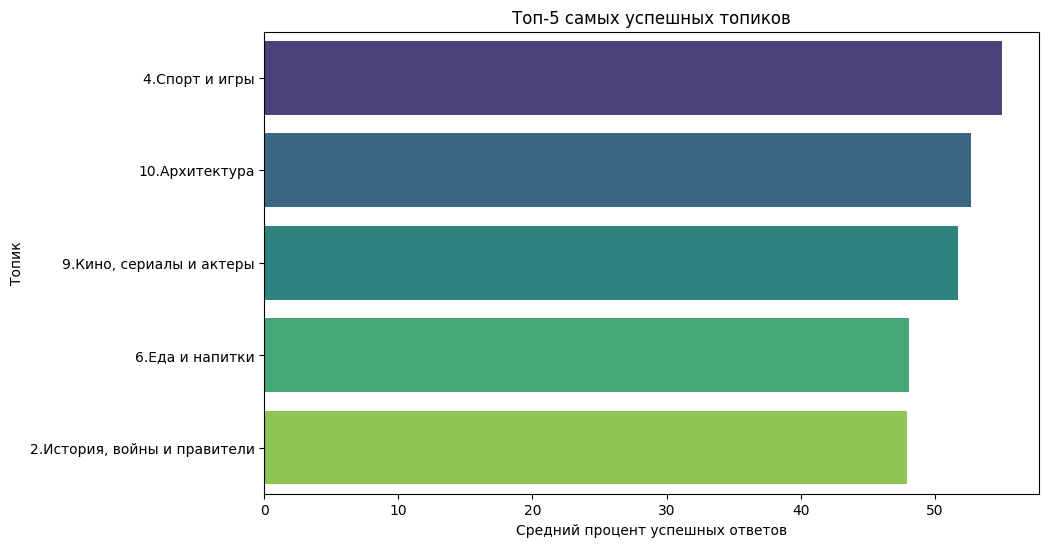

In [49]:
plt.figure(figsize=(10, 6))
top_topics = topic_success.head(5)
sns.barplot(x='Процент взятия', y='topic_name', data=top_topics, palette='viridis')
plt.title('Топ-5 самых успешных топиков')
plt.xlabel('Средний процент успешных ответов')
plt.ylabel('Топик')
plt.show()

# СВОДНАЯ ТАБЛИЦА

In [28]:
import json

selected_columns = df[['id', 'topic_id', 'topic_name']]
selected_columns.to_json('theme_topics_data.json', orient='records', force_ascii=False, indent=2)

print("Информация о кластерах успешно добавлена!")

Информация о кластерах успешно добавлена!


In [ ]:
custom_names = {
    -1: "Шум",
    0: "Произведения и персонажи",
    1: "Языки и загадки",
    2: "История, войны и правители",
    3: "Наука и природа",
    4: "Спорт и игры",
    5: "Религии и традиции",
    6: "Еда и напитки",
    7: "Литература",
    8: "Музыка",
    9: "Кино, сериалы и актеры",
    10: "Архитектура",
    11: "Технологии",
    12: "Люди и события",
    13: "Медицина"
}

df['topic_name'] = df['topic_id'].map(custom_names)
df = df.drop(columns=['original_text'])
df = df.drop(columns=['fully_processed_text'])
df = df.drop(columns=['cleaned_text'])
df